<a href="https://colab.research.google.com/github/ovbystrova/dpl/blob/master/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://github.com/williamSYSU/TextGAN-PyTorch
# https://github.com/DSleeps/Text-GAN
# https://github.com/rtst777/TextGAN
# https://github.com/MuratArda-coder/GAN-Text-Generation

In [0]:
# Либо убрать BPTT Итератор, либо зашафлить его, либо для дисприминатора сделать обычный итератор
# LeakyReLU = good (in both G and D)
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
# make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [1]:
!git clone https://github.com/ovbystrova/dpl.git
import os
os.chdir('/content/dpl')

Cloning into 'dpl'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 244 (delta 3), reused 6 (delta 2), pack-reused 234
Receiving objects: 100% (244/244), 340.18 MiB | 13.90 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (36/36), done.


In [0]:
%%capture
!pip install tokenizers
!pip install wandb
!wandb login 

In [3]:
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

import matplotlib.pyplot as plt
import numpy as np
import math
from collections import namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from utils import loss_functions
from utils.train_lm import mle_train, _test_epoch, _train_epoch
from utils.sntpiece_tokenization import make_tokenizer, clean_data, special_tokens
from models.generator_simple import SimpleG
from models.discriminator_simple import SimpleD
from models.RelGAN_D import RelGAN_D
from tqdm import tqdm

def clean_tqdm():
    for instance in list(tqdm._instances): 
        tqdm._decr_instances(instance)
for e in tqdm([1,2,3]):
    pass

100%|██████████| 3/3 [00:00<00:00, 17524.95it/s]


In [0]:
LM_PATH = 'data/lm_base'
BATCH_SIZE = 64
SEQ_LENGTH = 40

#Data

In [0]:
%%capture
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

In [7]:
tokenizer = make_tokenizer()
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
%%capture
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens
    
TEXT = data.Field(sequential=True, 
                  include_lengths=False, 
                  batch_first=True, 
                  tokenize=tokenize,
                  lower=True, 
                  pad_first=True, 
                  )

train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

In [9]:
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 22734


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

In [0]:
train_iterator_g, valid_iterator_g, test_iterator_g = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)

train_iterator_d, valid_iterator_d, test_iterator_d = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)

# Model

## Generator check

In [0]:
generator = SimpleG(vocab_size=len(TEXT.vocab.itos),
                embed_dim=200,
                hidden_size=128,
               )
generator.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=1)
criterion.to(device);

In [12]:
for el in train_iterator_g:
    with torch.no_grad():
        x = el.text
        y = el.target.T
        print('X and Y sizes', x.size(), y.size())
        preds = generator(el)
        print('Generator pred size: ', preds.size())
        loss = criterion(preds.transpose(1,2), y)
        print('Loss whole: ', loss)
    break

print('Initial CrossEntropy: ', _test_epoch(generator, test_iterator_g, criterion)[0])
generator.load_state_dict(torch.load(LM_PATH))
print('Loaded CrossEntropy: ', _test_epoch(generator, test_iterator_g, criterion)[0])

X and Y sizes torch.Size([40, 64]) torch.Size([64, 40])
Generator pred size:  torch.Size([64, 40, 22734])
Loss whole:  tensor(10.0263, device='cuda:0')


In [0]:
# Pre-train generator if needed

# optimizer = optim.Adam(generator.parameters(), lr=1e-2)
# train_losses, valid_losses = mle_train(generator, train_iterator_g, valid_iterator_g, criterion=criterion, optimizer=optimizer, 
#         n_epochs=10, early_stopping=2)

# print('Trained CrossEntropy: ', _test_epoch(generator, test_iterator_g, criterion)[0])
# print('Trained NLLL: ', _test_epoch(generator, test_iterator_g, criterion=critnll)[0])

## Discriminator

### RelGAN check

https://github.com/williamSYSU/TextGAN-PyTorch

In [0]:
discriminator = RelGAN_D(embed_dim=200,
                         max_seq_len=SEQ_LENGTH+10,
                         num_rep=1,
                         vocab_size=len(TEXT.vocab),
                         dis_num_filters=[300,300,300],
                         dis_filter_sizes=[2,3,4], 
                         weights='uniform')
discriminator.to(device);

In [15]:
for el in train_iterator_d:
    with torch.no_grad():
        x = el.text.T
        
        x_gen = F.gumbel_softmax(generator(el), dim=-1, hard=True,  tau=1)
        print('X generated size: ', x_gen.size())

        x_dis = F.one_hot(x, len(TEXT.vocab)).float()
        print('X real size: ', x_dis.size())

        out_fake = discriminator(x_gen)
        out_real = discriminator(x_dis)
        print('Discriminator fake and real sizes: ', out_fake.size(), out_real.size())

        d_loss, g_loss = loss_functions.rsgan(out_real, out_fake)
        print('Discriminator loss: ', d_loss)
        print('Generator loss: ', g_loss)
        break

X generated size:  torch.Size([64, 40, 22734])
X real size:  torch.Size([64, 40, 22734])
Discriminator fake and real sizes:  torch.Size([64]) torch.Size([64])
Discriminator loss:  tensor(0.6930, device='cuda:0')
Generator loss:  tensor(0.6933, device='cuda:0')


### LeakGAN

In [0]:
# https://github.com/nurpeiis/LeakGAN-PyTorch/blob/master/Discriminator.py

### SimpleD check

In [0]:
simple_d = SimpleD(embed_dim=200,
                    max_seq_len=SEQ_LENGTH+10,
                    vocab_size=len(TEXT.vocab),
                    weights = 'normal')
simple_d.to(device);

In [19]:
for el in train_iterator_d:
    with torch.no_grad():
        x = el.text.T
        
        x_gen = F.gumbel_softmax(generator(el), dim=-1, hard=True,  tau=1)
        print('X generated size: ', x_gen.size())

        x_dis = F.one_hot(x, len(TEXT.vocab)).float()
        print('X real size: ', x_dis.size())
        # If not works then loop for x in x_dis and every one to float

        out_fake = simple_d(x_gen)
        out_real = simple_d(x_dis)
        print('Discriminator fake and real sizes: ', out_fake.size(), out_real.size())
        # print(out_fake, out_real)

        d_loss, g_loss = loss_functions.rsgan(out_real, out_fake)
        print('Discriminator loss: ', d_loss)
        print('Generator loss: ', g_loss)
        break

X generated size:  torch.Size([64, 40, 22734])
X real size:  torch.Size([64, 40, 22734])
Discriminator fake and real sizes:  torch.Size([64, 1]) torch.Size([64, 1])
Discriminator loss:  tensor(3.4980, device='cuda:0')
Generator loss:  tensor(2.7603, device='cuda:0')


# GAN with instructor

In [0]:
def get_loss(real, fake, loss_type):
    if loss_type =='standart':
        return loss_functions.standart(real, fake)
    elif loss_type == 'js':
        return loss_functions.js(real, fake)
    elif loss_type == 'kl':
        return loss_functions.kl(real, fake)
    elif loss_type == 'hinge':
        return loss_functions.hinge(real, fake)
    elif loss_type == 'total_var':
        return loss_functions.total_var(real, fake)
    elif loss_type =='rsgan':
        return loss_functions.rsgan(real, fake)
    else:
        return'Trying to use not implemented loss function'

In [0]:
class GANInstructor:
    def __init__(self, generator, discriminator):
        super(GANInstructor, self).__init__()

        self.gen = generator
        self.dis = discriminator
        self.criterion = nn.CrossEntropyLoss(ignore_index=1)
        self.criterion.to(device)
        self.n_epochs = wandb_config['num_epochs']
        # Optimizer
        self.gen_adv_opt = optim.Adam(self.gen.parameters(), lr=wandb_config['lr_gen'])
        self.dis_opt = optim.SGD(self.dis.parameters(), lr=wandb_config['lr_dis'])
        # Iterators
        self.len_train = len(train_iterator_g)
        self.len_valid = len(valid_iterator_g)
        # Losses
        self.dis_losses_train, self.dis_losses_valid = [], []
        self.gen_losses_train, self.gen_losses_valid = [], []
        self.crossentropy_train, self.crossentropy_valid = [], []
    
    def _run(self):
        """
        Runs training process. 
        """
        progress = tqdm(range(self.n_epochs))
        for adv_epoch in progress:
            # g_loss = self.adv_train_generator(epoch=adv_epoch)  # Generator
            # d_loss = self.adv_train_discriminator(epoch=adv_epoch)  # Discriminator         
            g_loss, d_loss = self._train(epoch=adv_epoch)
            g_loss_valid, d_loss_valid = self._test(epoch=adv_epoch)        
            print()
            print('g_loss: %.4f, d_loss: %.4f, g_loss_valid: %.4f, d_loss_valid: %.4f' % (g_loss, d_loss, g_loss_valid, d_loss_valid))

            # if adv_epoch % 2 == 1 :
            torch.save(self.gen.state_dict(), '/content/gen_{}'.format(adv_epoch))
            torch.save(self.dis.state_dict(), '/content/dis_{}'.format(adv_epoch))


    def _test(self, epoch):
        """
        Validation epoch
        """
        self.gen.eval()
        self.dis.eval()
        g_loss_total, d_loss_total = 0, 0
        for ind, batch in enumerate(zip(valid_iterator_g, valid_iterator_d)):
            if ind == len(valid_iterator_g)-1:
                continue
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_pred = self.gen(gen_samples)
            gen_samples = F.gumbel_softmax(gen_pred, 
                                           dim=-1, 
                                           hard=True, 
                                           tau=wandb_config['temperature'])
            real_samples = F.one_hot(real_samples, len(TEXT.vocab.itos)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)
            g_loss, d_loss = get_loss(real=d_out_real, fake=d_out_fake, loss_type=wandb_config['loss'])
            self.gen_losses_valid.append(g_loss.item())
            self.dis_losses_valid.append(d_loss.item())
            g_loss_total += g_loss.item()
            d_loss_total += d_loss.item() 

            crossentr = self.criterion(gen_pred.transpose(1,2) ,batch[0].target.T).item()
            
            wandb_step = epoch*self.len_valid+ind+1
            wandb.log({"Generator Valid loss" :  g_loss.item(), 
                       'Discriminator Valid loss': d_loss.item(), 
                       'CrossEntropy_valid' : crossentr,
                       'iteration_valid' : wandb_step})
        return g_loss_total / len(valid_iterator_g), d_loss_total / len(valid_iterator_d)

    def _train(self, epoch):
        """
        Train epoch. At every batch step generator makes his move,
        then discriminator updates
        """
        self.gen.train()
        self.dis.train()
        g_loss_total, d_loss_total = 0, 0
        for ind, batch in enumerate(zip(train_iterator_g, train_iterator_d)):
            if ind == len(train_iterator_g)-1:
                continue
            # Optimizing Generator
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_pred = self.gen(gen_samples)
            gen_samples = F.gumbel_softmax(gen_pred, 
                                           dim=-1, 
                                           hard=True,  
                                           tau=wandb_config['temperature'])
            real_samples = F.one_hot(real_samples,  len(TEXT.vocab.itos)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)

            g_loss, _ = get_loss(real=d_out_real, fake=d_out_fake, loss_type=wandb_config['loss'])
            self.optimize(self.gen_adv_opt, g_loss, self.gen)
            self.gen_losses_train.append(g_loss.item())
            g_loss_total += g_loss.item()

            # Optimizing Discriminator
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_samples = F.gumbel_softmax(self.gen(gen_samples), 
                                           dim=-1, 
                                           hard=True,
                                           tau=wandb_config['temperature'])
            real_samples = F.one_hot(real_samples, len(TEXT.vocab.itos)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)
            _, d_loss = get_loss(real=d_out_real, fake=d_out_fake, loss_type=wandb_config['loss'])
            self.optimize(self.dis_opt, d_loss, self.dis)
            self.dis_losses_train.append(d_loss.item())
            d_loss_total += d_loss.item() 
            
            crossentr = self.criterion(gen_pred.transpose(1,2) ,batch[0].target.T).item()
            
            wandb_step = epoch*self.len_train+ind+1
            wandb.log({"Generator Train loss" :  g_loss.item(), 
                       'Discriminator Train loss' : d_loss.item(),
                       'CrossEntropy_train' : crossentr, 
                       'iteration_train_g': wandb_step})
        return g_loss_total / len(train_iterator_g), d_loss_total / len(train_iterator_d)

    @staticmethod
    def optimize(opt, loss, model=None, retain_graph=False):
        opt.zero_grad()
        loss.backward(retain_graph=retain_graph)
        if model is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), wandb_config['weight_clip'])
        opt.step()

In [0]:
wandb_config = {
    'lr_gen' : 1e-3,
    'lr_dis' : 1e-6,
    'gan' : 'relgan',
    'weight_clip' : 5,
    'num_epochs' : 10,
    'temperature': 1, 
    'loss' : 'js',
    'pretrain_lm': 'yes',
    'weights': 'normal'
    }

RUN_ID = 'gan32'

In [82]:
wandb.init(id=RUN_ID, config=wandb_config, project='dpl')

W&B Run: https://app.wandb.ai/2ispany3/dpl/runs/gan32

In [83]:
generator = SimpleG(vocab_size=len(TEXT.vocab.itos),
                embed_dim=200,
                hidden_size=128,
               )
generator.to(device)
generator.load_state_dict(torch.load(LM_PATH))
ce = _test_epoch(generator, test_iterator_g, criterion)[0]
wandb.log({'CrossEntropy_Before':ce})
print('CrossEntropy before gan: ', ce)
discriminator = RelGAN_D(embed_dim=200,
                         max_seq_len=SEQ_LENGTH+10,
                         num_rep=1,
                         vocab_size=len(TEXT.vocab),
                         dis_num_filters=[300,300],
                         dis_filter_sizes=[2,3], 
                         weights=wandb_config['weights'])
# discriminator = SimpleD(embed_dim=200,
#                     max_seq_len=SEQ_LENGTH+10,
#                     vocab_size=len(TEXT.vocab),
#                     weights = wandb_config['weights'])
discriminator.to(device);
discriminator.to(device);
instructor = GANInstructor(generator=generator, discriminator=discriminator)

CrossEntropy before gan:  0.16182326376438141


In [0]:
clean_tqdm()
instructor._run()

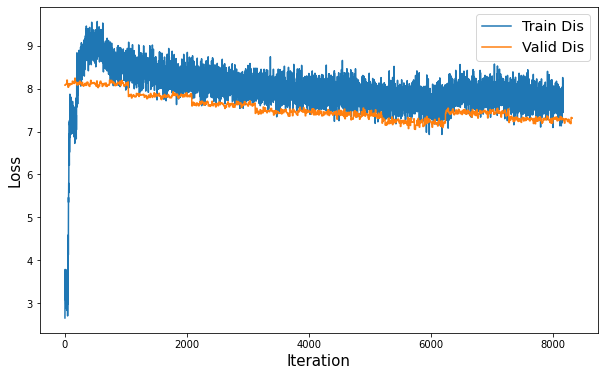

In [85]:
new_val = [el for el in instructor.dis_losses_valid for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(instructor.dis_losses_train)), instructor.dis_losses_train, label='Train Dis')
plt.plot(np.arange(len(new_val)), new_val, label='Valid Dis')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

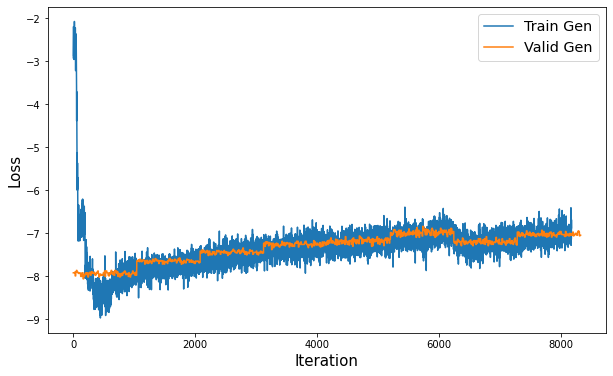

In [86]:
plt.figure(figsize=(10,6))
new_val = [el for el in instructor.gen_losses_valid for i in range(10)]
plt.plot(np.arange(len(instructor.gen_losses_train)), instructor.gen_losses_train, label='Train Gen')
plt.plot(np.arange(len(new_val)), new_val, label='Valid Gen')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

In [0]:
cross = _test_epoch(instructor.gen, test_iterator_g, criterion)[0]
print(cross)
# wandb.log({'CrossEntropy_After': cross})

In [0]:
instructor.gen.load_state_dict(torch.load('/content/gen_8'))
cross = _test_epoch(instructor.gen, test_iterator_g, criterion)[0]
wandb.log({'CrossEntropy_After': cross})